In [46]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 100)
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import  cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import  KNeighborsRegressor
# ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.metrics import accuracy_score

In [97]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submit.csv",header=None)

In [98]:
train

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17,0,0,-1,-1
1,2010-07-02,18,0,0,-1,-1
2,2010-07-03,20,0,0,-1,-1
3,2010-07-04,20,0,0,-1,-1
4,2010-07-05,14,0,0,-1,-1
...,...,...,...,...,...,...
2096,2016-03-27,94,1,0,5,4
2097,2016-03-28,86,1,0,4,4
2098,2016-03-29,98,1,0,4,4
2099,2016-03-30,99,1,0,5,4


In [99]:
test

,datetime,client,close,price_am,price_pm
0,2016-04-01,1,0,3,2
1,2016-04-02,0,0,5,5
2,2016-04-03,1,0,2,2
3,2016-04-04,1,0,1,1
4,2016-04-05,0,0,1,1
...,...,...,...,...,...
360,2017-03-27,0,0,5,4
361,2017-03-28,0,0,4,4
362,2017-03-29,0,0,3,3
363,2017-03-30,0,0,4,3


In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  2101 non-null   object
 1   y         2101 non-null   int64 
 2   client    2101 non-null   int64 
 3   close     2101 non-null   int64 
 4   price_am  2101 non-null   int64 
 5   price_pm  2101 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 98.6+ KB


/Users/takeuchiakirayuu/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y', ylabel='Density'>

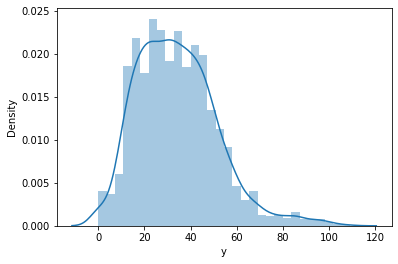

In [101]:
sns.distplot(train["y"])

In [102]:
train.describe()

,y,client,close,price_am,price_pm
count,2101.000000,2101.000000,2101.000000,2101.000000,2101.000000
mean,34.096621,0.098049,0.012851,0.614469,0.390766
std,17.476234,0.297451,0.112658,1.127940,0.975456
min,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,0.000000,0.000000,1.000000,1.000000
max,109.000000,1.000000,1.000000,5.000000,5.000000


##  前処理

In [103]:
train["datetime"]= pd.to_datetime(train["datetime"])
test["datetime"]= pd.to_datetime(test["datetime"])

In [104]:
train["month"]=train["datetime"].dt.month
train["day"]=train["datetime"].dt.day
train["year"]=train["datetime"].dt.year
test["month"]=test["datetime"].dt.month
test["day"]=test["datetime"].dt.day
test["year"]=test["datetime"].dt.year

## 特徴量の作成¶

In [105]:
train["price_am"].iloc[train["price_am"]==-1]=0
train["price_pm"].iloc[train["price_pm"]==-1]=0
test["price_am"].iloc[test["price_am"]==-1]=0
test["price_pm"].iloc[test["price_pm"]==-1]=0

/Users/takeuchiakirayuu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/takeuchiakirayuu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/takeuchiakirayuu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [106]:
train['am*pm'] = train['price_am']*train['price_pm']
train['cli*clo'] = train['client']*train['close']
train['cli*am'] = train['client']*train['price_am']
train['cli*pm'] = train['client']*train['price_pm']
train['clo*am'] = train['close']*train['price_am']
train['clo*pm'] = train['close']*train['price_pm']

train['am+pm'] = train['price_am']+train['price_pm']
train['cli+clo'] = train['client']+train['close']
train['cli+am'] = train['client']+train['price_am']
train['cli+pm'] = train['client']+train['price_pm']
train['clo+am'] = train['close']+train['price_am']
train['clo+pm'] = train['close']+train['price_pm']

train['am-pm'] = train['price_am']-train['price_pm']
train['cli-clo'] = train['client']-train['close']
train['cli-am'] = train['client']-train['price_am']
train['cli-pm'] = train['client']-train['price_pm']
train['clo-am'] = train['close']-train['price_am']
train['clo-pm'] = train['close']-train['price_pm']
#ラグ特徴量、移動平均、日付
train['oneday_before_am'] = train['price_am'].shift(1)
train['oneday_before_pm'] = train['price_pm'].shift(1)
train['rel_3am'] = train['price_am'].rolling(7).sum()
train['rel_3pm'] = train['price_pm'].rolling(7).sum()
train['rel_3cli'] = train['client'].rolling(7).sum()
train['rel_3clo'] = train['close'].rolling(7).sum()
train['datetime'] = pd.to_datetime(train['datetime']) 
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['dayofweek'] = train['datetime'].dt.dayofweek


test['am*pm'] = test['price_am']*test['price_pm']
test['cli*clo'] = test['client']*test['close']
test['cli*am'] = test['client']*test['price_am']
test['cli*pm'] = test['client']*test['price_pm']
test['clo*am'] = test['close']*test['price_am']
test['clo*pm'] = test['close']*test['price_pm']

test['am+pm'] = test['price_am']+test['price_pm']
test['cli+clo'] = test['client']+test['close']
test['cli+am'] = test['client']+test['price_am']
test['cli+pm'] = test['client']+test['price_pm']
test['clo+am'] = test['close']+test['price_am']
test['clo+pm'] = test['close']+test['price_pm']

test['am-pm'] = test['price_am']-test['price_pm']
test['cli-clo'] = test['client']-test['close']
test['cli-am'] = test['client']-test['price_am']
test['cli-pm'] = test['client']-test['price_pm']
test['clo-am'] = test['close']-test['price_am']
test['clo-pm'] = test['close']-test['price_pm']
test['oneday_before_am'] = test['price_am'].shift(1)
test['oneday_before_pm'] = test['price_pm'].shift(1)
test['rel_3am'] = test['price_am'].rolling(7).sum()
test['rel_3pm'] = test['price_pm'].rolling(7).sum()
test['rel_3cli'] = test['client'].rolling(7).sum()
test['rel_3clo'] = test['close'].rolling(7).sum()
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['dayofweek'] = test['datetime'].dt.dayofweek


##  lightgbm

In [107]:
data = pd.concat([train, test], sort = False)
categorical_features = []
delete_columns =["datetime"]


In [108]:
data = data.drop(delete_columns, axis=1)
train = data[:len(train)]
test = data[len(train):]


In [109]:
y_train = train['y']
X_train = train.drop('y', axis=1)
X_test = test.drop('y', axis = 1)


In [76]:
models = []

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=42)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            categorical_feature=categorical_features,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           categorical_feature=categorical_features,
                           free_raw_data=False)
    
    # パラメータを設定
    params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'rmse'}        # データの最小数（初期値20）
             }
    
    # 学習
    evaluation_results = {}                                     # 学習の経過を保存する箱
    model = lgb.train(params,                                   # 上記で設定したパラメータ
                      lgb_train,                                # 使用するデータセット
                      num_boost_round=1000,                     # 学習の回数
                      valid_names=['train', 'valid'],           # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                      evals_result=evaluation_results,          # 学習の経過を保存
                      categorical_feature=categorical_features, # カテゴリー変数を設定
                      early_stopping_rounds=20,                 # アーリーストッピング# 学習
                      verbose_eval=-1)                          # 学習の経過の非表示
    
    # テストデータで予測する
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
  

    
    
    # 学習が終わったモデルをリストに入れておく
    models.append(model) 

/Users/takeuchiakirayuu/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[101]	train's rmse: 3.83549	valid's rmse: 7.14469
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[74]	train's rmse: 4.27498	valid's rmse: 7.0201
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[165]	train's rmse: 3.28798	valid's rmse: 6.90584
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[154]	train's rmse: 3.21107	valid's rmse: 6.87172
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[68]	train's rmse: 4.52241	valid's rmse: 6.54595


In [77]:
mse = mean_squared_error( y_train, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) #RSME = √MSEの算出
print('RMSE :',rmse)
mae =mean_absolute_error( y_train, y_pred)
print("MAE:",mae)
#r2 : 決定係数
r2 = r2_score( y_train,y_pred)
print('R2 :',r2)

RMSE : 4.993156409561599
MAE: 3.816973870171851
R2 : 0.9159746416575297


In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,random_state=0)



lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)


params = {

        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'L1'}
}




model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=1000,
    early_stopping_rounds=100
)

y_pred = model.predict(X_train, num_iteration=model.best_iteration)
# テストデータの予測


/Users/takeuchiakirayuu/.local/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[50]	training's l1: 3.86903	valid_1's l1: 5.17303
[100]	training's l1: 3.12033	valid_1's l1: 5.11396
[150]	training's l1: 2.70223	valid_1's l1: 5.12509
[200]	training's l1: 2.41097	valid_1's l1: 5.16891
Early stopping, best iteration is:
[108]	training's l1: 3.03876	valid_1's l1: 5.10054


In [75]:
mse = mean_squared_error(y_train , y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) #RSME = √MSEの算出
print('RMSE :',rmse)
mae =mean_absolute_error(y_train , y_pred)
print("MAE:",mae)
#r2 : 決定係数
r2 = r2_score(y_train ,y_pred)
print('R2 :',r2)

RMSE : 3.8732312573446452
MAE: 3.0387568239229448
R2 : 0.9494400205956429


In [417]:
test

,y,client,close,price_am,price_pm,month,day,year,am*pm,cli*clo,...,cli-pm,clo-am,clo-pm,oneday_before_am,oneday_before_pm,rel_3am,rel_3pm,rel_3cli,rel_3clo,dayofweek
0,NaN,1,0,3,2,4,1,2016,6,0,...,-1,-3,-2,NaN,NaN,NaN,NaN,NaN,NaN,4
1,NaN,0,0,5,5,4,2,2016,25,0,...,-5,-5,-5,3.0,2.0,NaN,NaN,NaN,NaN,5
2,NaN,1,0,2,2,4,3,2016,4,0,...,-1,-2,-2,5.0,5.0,NaN,NaN,NaN,NaN,6
3,NaN,1,0,1,1,4,4,2016,1,0,...,0,-1,-1,2.0,2.0,NaN,NaN,NaN,NaN,0
4,NaN,0,0,1,1,4,5,2016,1,0,...,-1,-1,-1,1.0,1.0,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,NaN,0,0,5,4,3,27,2017,20,0,...,-4,-5,-4,4.0,4.0,27.0,28.0,2.0,0.0,0
361,NaN,0,0,4,4,3,28,2017,16,0,...,-4,-4,-4,5.0,4.0,27.0,28.0,1.0,0.0,1
362,NaN,0,0,3,3,3,29,2017,9,0,...,-3,-3,-3,4.0,4.0,28.0,27.0,1.0,0.0,2
363,NaN,0,0,4,3,3,30,2017,12,0,...,-3,-4,-3,3.0,3.0,29.0,28.0,1.0,0.0,3


In [47]:
sample[1]=y_pred
sample.to_csv("submit.csv",index=None,header=None)

## catboost


In [53]:
pip install catboost

     |████████████████████████████████| 11.1MB 15.3MB/s eta 0:00:01
     |████████████████████████████████| 13.2MB 4.9MB/s eta 0:00:01    |█████████████▌                  | 5.6MB 9.6MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11429 sha256=13c68846611caea1d8ab496ba165509bfd0a79cc59a955b49eb4a493bc174199
  Stored in directory: /Users/takeuchiakirayuu/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [78]:
from catboost import CatBoostRegressor, FeaturesData, Pool

def split_features(df):
    cfc = []
    nfc = []
    for column in df:
        if column == 'Origin':
            cfc.append(column)
        else:
            nfc.append(column)
    return df[cfc], df[nfc]

In [80]:
data = pd.concat([train, test], sort = False)

train = data[:len(train)]
test = data[len(train):]
y_train = train['y']
X_train = train.drop('y', axis=1)
X_test = test.drop('y', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                        test_size=0.3,
                                                        shuffle=True,
                                                        random_state=42)

    # scikit-learn インターフェースを備えたラッパー
model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=5
                           )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
# 確率がほしいときは predict_proba() を使う
y_pred = model.predict(_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

0:	learn: 16.9282900	test: 17.0204820	best: 17.0204820 (0)	total: 52.1ms	remaining: 1m 44s
1:	learn: 16.4535392	test: 16.5844160	best: 16.5844160 (1)	total: 55.5ms	remaining: 55.4s
2:	learn: 15.9572159	test: 16.1009953	best: 16.1009953 (2)	total: 58.6ms	remaining: 39s
3:	learn: 15.5049085	test: 15.6673361	best: 15.6673361 (3)	total: 61ms	remaining: 30.4s
4:	learn: 15.0894851	test: 15.2602815	best: 15.2602815 (4)	total: 63.7ms	remaining: 25.4s
5:	learn: 14.6896943	test: 14.8888657	best: 14.8888657 (5)	total: 65ms	remaining: 21.6s
6:	learn: 14.3089749	test: 14.5268906	best: 14.5268906 (6)	total: 67.1ms	remaining: 19.1s
7:	learn: 13.9503121	test: 14.1796761	best: 14.1796761 (7)	total: 69.3ms	remaining: 17.3s
8:	learn: 13.6175106	test: 13.8777519	best: 13.8777519 (8)	total: 72.1ms	remaining: 16s
9:	learn: 13.3046403	test: 13.5630728	best: 13.5630728 (9)	total: 74.4ms	remaining: 14.8s
10:	learn: 13.0098210	test: 13.2735998	best: 13.2735998 (10)	total: 75.8ms	remaining: 13.7s
11:	learn: 12.7

112:	learn: 7.2659745	test: 7.6736489	best: 7.6736489 (112)	total: 214ms	remaining: 3.58s
113:	learn: 7.2616688	test: 7.6671359	best: 7.6671359 (113)	total: 216ms	remaining: 3.58s
114:	learn: 7.2468697	test: 7.6497436	best: 7.6497436 (114)	total: 219ms	remaining: 3.58s
115:	learn: 7.2446774	test: 7.6506721	best: 7.6497436 (114)	total: 222ms	remaining: 3.6s
116:	learn: 7.2399467	test: 7.6523514	best: 7.6497436 (114)	total: 224ms	remaining: 3.61s
117:	learn: 7.2316556	test: 7.6457093	best: 7.6457093 (117)	total: 227ms	remaining: 3.62s
118:	learn: 7.2149345	test: 7.6267777	best: 7.6267777 (118)	total: 229ms	remaining: 3.62s
119:	learn: 7.2127342	test: 7.6261507	best: 7.6261507 (119)	total: 231ms	remaining: 3.62s
120:	learn: 7.2010370	test: 7.6276627	best: 7.6261507 (119)	total: 233ms	remaining: 3.62s
121:	learn: 7.1832154	test: 7.6218914	best: 7.6218914 (121)	total: 235ms	remaining: 3.62s
122:	learn: 7.1673037	test: 7.6195813	best: 7.6195813 (122)	total: 237ms	remaining: 3.62s
123:	learn:

220:	learn: 6.3221001	test: 7.1593786	best: 7.1593786 (220)	total: 381ms	remaining: 3.07s
221:	learn: 6.3215755	test: 7.1593821	best: 7.1593786 (220)	total: 383ms	remaining: 3.07s
222:	learn: 6.3209505	test: 7.1595155	best: 7.1593786 (220)	total: 385ms	remaining: 3.06s
223:	learn: 6.3203888	test: 7.1591910	best: 7.1591910 (223)	total: 386ms	remaining: 3.06s
224:	learn: 6.3197338	test: 7.1588678	best: 7.1588678 (224)	total: 388ms	remaining: 3.06s
225:	learn: 6.3105768	test: 7.1551621	best: 7.1551621 (225)	total: 390ms	remaining: 3.06s
226:	learn: 6.3099398	test: 7.1548418	best: 7.1548418 (226)	total: 391ms	remaining: 3.05s
227:	learn: 6.2994383	test: 7.1435598	best: 7.1435598 (227)	total: 393ms	remaining: 3.05s
228:	learn: 6.2906881	test: 7.1439409	best: 7.1435598 (227)	total: 395ms	remaining: 3.05s
229:	learn: 6.2808924	test: 7.1377361	best: 7.1377361 (229)	total: 397ms	remaining: 3.05s
230:	learn: 6.2735880	test: 7.1353981	best: 7.1353981 (230)	total: 399ms	remaining: 3.05s
231:	learn

400:	learn: 5.3645226	test: 6.7955328	best: 6.7955328 (400)	total: 552ms	remaining: 2.2s
401:	learn: 5.3588211	test: 6.7965320	best: 6.7955328 (400)	total: 553ms	remaining: 2.2s
402:	learn: 5.3564727	test: 6.7980342	best: 6.7955328 (400)	total: 554ms	remaining: 2.19s
403:	learn: 5.3528397	test: 6.7975221	best: 6.7955328 (400)	total: 555ms	remaining: 2.19s
404:	learn: 5.3513677	test: 6.7974905	best: 6.7955328 (400)	total: 556ms	remaining: 2.19s
405:	learn: 5.3500310	test: 6.7972584	best: 6.7955328 (400)	total: 556ms	remaining: 2.18s
406:	learn: 5.3457022	test: 6.7943145	best: 6.7943145 (406)	total: 557ms	remaining: 2.18s
407:	learn: 5.3390976	test: 6.7957455	best: 6.7943145 (406)	total: 558ms	remaining: 2.18s
408:	learn: 5.3341414	test: 6.7949079	best: 6.7943145 (406)	total: 559ms	remaining: 2.17s
409:	learn: 5.3298875	test: 6.7912890	best: 6.7912890 (409)	total: 559ms	remaining: 2.17s
410:	learn: 5.3264869	test: 6.7920023	best: 6.7912890 (409)	total: 561ms	remaining: 2.17s
411:	learn: 

572:	learn: 4.7779090	test: 6.6543259	best: 6.6543259 (572)	total: 728ms	remaining: 1.81s
573:	learn: 4.7747484	test: 6.6527283	best: 6.6527283 (573)	total: 730ms	remaining: 1.81s
574:	learn: 4.7721056	test: 6.6534399	best: 6.6527283 (573)	total: 731ms	remaining: 1.81s
575:	learn: 4.7686317	test: 6.6530188	best: 6.6527283 (573)	total: 733ms	remaining: 1.81s
576:	learn: 4.7654648	test: 6.6524598	best: 6.6524598 (576)	total: 735ms	remaining: 1.81s
577:	learn: 4.7625932	test: 6.6514192	best: 6.6514192 (577)	total: 736ms	remaining: 1.81s
578:	learn: 4.7614539	test: 6.6523205	best: 6.6514192 (577)	total: 738ms	remaining: 1.81s
579:	learn: 4.7613162	test: 6.6521813	best: 6.6514192 (577)	total: 740ms	remaining: 1.81s
580:	learn: 4.7588710	test: 6.6521354	best: 6.6514192 (577)	total: 742ms	remaining: 1.81s
581:	learn: 4.7564433	test: 6.6515783	best: 6.6514192 (577)	total: 743ms	remaining: 1.81s
582:	learn: 4.7533553	test: 6.6490849	best: 6.6490849 (582)	total: 745ms	remaining: 1.81s
583:	learn

706:	learn: 4.4606316	test: 6.6129902	best: 6.6108557 (689)	total: 906ms	remaining: 1.66s
707:	learn: 4.4554405	test: 6.6115276	best: 6.6108557 (689)	total: 908ms	remaining: 1.66s
708:	learn: 4.4529886	test: 6.6121631	best: 6.6108557 (689)	total: 909ms	remaining: 1.65s
709:	learn: 4.4501039	test: 6.6133166	best: 6.6108557 (689)	total: 910ms	remaining: 1.65s
710:	learn: 4.4486500	test: 6.6151317	best: 6.6108557 (689)	total: 911ms	remaining: 1.65s
711:	learn: 4.4484451	test: 6.6150306	best: 6.6108557 (689)	total: 911ms	remaining: 1.65s
712:	learn: 4.4479043	test: 6.6157730	best: 6.6108557 (689)	total: 912ms	remaining: 1.65s
713:	learn: 4.4478027	test: 6.6155826	best: 6.6108557 (689)	total: 914ms	remaining: 1.65s
714:	learn: 4.4459481	test: 6.6148078	best: 6.6108557 (689)	total: 916ms	remaining: 1.65s
715:	learn: 4.4421780	test: 6.6155471	best: 6.6108557 (689)	total: 918ms	remaining: 1.65s
716:	learn: 4.4407434	test: 6.6163523	best: 6.6108557 (689)	total: 920ms	remaining: 1.65s
717:	learn

903:	learn: 4.1078796	test: 6.5992990	best: 6.5966933 (866)	total: 1.08s	remaining: 1.31s
904:	learn: 4.1055332	test: 6.5997199	best: 6.5966933 (866)	total: 1.08s	remaining: 1.31s
905:	learn: 4.1031153	test: 6.6001167	best: 6.5966933 (866)	total: 1.08s	remaining: 1.3s
906:	learn: 4.1019788	test: 6.5997355	best: 6.5966933 (866)	total: 1.08s	remaining: 1.3s
907:	learn: 4.0992105	test: 6.5995147	best: 6.5966933 (866)	total: 1.08s	remaining: 1.3s
908:	learn: 4.0975522	test: 6.5990157	best: 6.5966933 (866)	total: 1.09s	remaining: 1.3s
909:	learn: 4.0974317	test: 6.5986943	best: 6.5966933 (866)	total: 1.09s	remaining: 1.3s
910:	learn: 4.0966472	test: 6.5989676	best: 6.5966933 (866)	total: 1.09s	remaining: 1.3s
911:	learn: 4.0932268	test: 6.5981485	best: 6.5966933 (866)	total: 1.09s	remaining: 1.3s
912:	learn: 4.0900079	test: 6.5963430	best: 6.5963430 (912)	total: 1.09s	remaining: 1.3s
913:	learn: 4.0883174	test: 6.5961444	best: 6.5961444 (913)	total: 1.09s	remaining: 1.3s
914:	learn: 4.08601

1106:	learn: 3.8005502	test: 6.5804347	best: 6.5804347 (1106)	total: 1.25s	remaining: 1.01s
1107:	learn: 3.8000567	test: 6.5803466	best: 6.5803466 (1107)	total: 1.25s	remaining: 1.01s
1108:	learn: 3.7990651	test: 6.5802924	best: 6.5802924 (1108)	total: 1.25s	remaining: 1.01s
1109:	learn: 3.7972289	test: 6.5806561	best: 6.5802924 (1108)	total: 1.25s	remaining: 1s
1110:	learn: 3.7956198	test: 6.5810772	best: 6.5802924 (1108)	total: 1.25s	remaining: 1s
1111:	learn: 3.7945508	test: 6.5814424	best: 6.5802924 (1108)	total: 1.26s	remaining: 1s
1112:	learn: 3.7921792	test: 6.5813428	best: 6.5802924 (1108)	total: 1.26s	remaining: 1s
1113:	learn: 3.7909522	test: 6.5811345	best: 6.5802924 (1108)	total: 1.26s	remaining: 1s
1114:	learn: 3.7896489	test: 6.5827167	best: 6.5802924 (1108)	total: 1.26s	remaining: 1s
1115:	learn: 3.7882507	test: 6.5827247	best: 6.5802924 (1108)	total: 1.26s	remaining: 1s
1116:	learn: 3.7879259	test: 6.5829987	best: 6.5802924 (1108)	total: 1.26s	remaining: 1s
1117:	learn:

1307:	learn: 3.5719290	test: 6.5689381	best: 6.5687211 (1305)	total: 1.42s	remaining: 754ms
1308:	learn: 3.5709538	test: 6.5688559	best: 6.5687211 (1305)	total: 1.43s	remaining: 753ms
1309:	learn: 3.5698060	test: 6.5690818	best: 6.5687211 (1305)	total: 1.43s	remaining: 752ms
1310:	learn: 3.5674678	test: 6.5684960	best: 6.5684960 (1310)	total: 1.43s	remaining: 751ms
1311:	learn: 3.5670287	test: 6.5689395	best: 6.5684960 (1310)	total: 1.43s	remaining: 750ms
1312:	learn: 3.5656030	test: 6.5680673	best: 6.5680673 (1312)	total: 1.43s	remaining: 750ms
1313:	learn: 3.5647582	test: 6.5684118	best: 6.5680673 (1312)	total: 1.43s	remaining: 749ms
1314:	learn: 3.5647286	test: 6.5683276	best: 6.5680673 (1312)	total: 1.44s	remaining: 748ms
1315:	learn: 3.5633925	test: 6.5690709	best: 6.5680673 (1312)	total: 1.44s	remaining: 747ms
1316:	learn: 3.5624810	test: 6.5686555	best: 6.5680673 (1312)	total: 1.44s	remaining: 746ms
1317:	learn: 3.5608021	test: 6.5690842	best: 6.5680673 (1312)	total: 1.44s	remai

1472:	learn: 3.4203820	test: 6.5744886	best: 6.5680673 (1312)	total: 1.6s	remaining: 573ms
1473:	learn: 3.4191380	test: 6.5748204	best: 6.5680673 (1312)	total: 1.6s	remaining: 572ms
1474:	learn: 3.4184845	test: 6.5746304	best: 6.5680673 (1312)	total: 1.6s	remaining: 571ms
1475:	learn: 3.4176944	test: 6.5742771	best: 6.5680673 (1312)	total: 1.6s	remaining: 570ms
1476:	learn: 3.4167875	test: 6.5743986	best: 6.5680673 (1312)	total: 1.61s	remaining: 569ms
1477:	learn: 3.4164913	test: 6.5745501	best: 6.5680673 (1312)	total: 1.61s	remaining: 568ms
1478:	learn: 3.4164745	test: 6.5744893	best: 6.5680673 (1312)	total: 1.61s	remaining: 567ms
1479:	learn: 3.4164516	test: 6.5744044	best: 6.5680673 (1312)	total: 1.61s	remaining: 566ms
1480:	learn: 3.4158057	test: 6.5745936	best: 6.5680673 (1312)	total: 1.61s	remaining: 565ms
1481:	learn: 3.4150302	test: 6.5747922	best: 6.5680673 (1312)	total: 1.61s	remaining: 564ms
1482:	learn: 3.4141254	test: 6.5737404	best: 6.5680673 (1312)	total: 1.61s	remaining

1695:	learn: 3.2554676	test: 6.5705396	best: 6.5680673 (1312)	total: 1.77s	remaining: 318ms
1696:	learn: 3.2551198	test: 6.5706320	best: 6.5680673 (1312)	total: 1.78s	remaining: 317ms
1697:	learn: 3.2547212	test: 6.5702725	best: 6.5680673 (1312)	total: 1.78s	remaining: 316ms
1698:	learn: 3.2540405	test: 6.5703575	best: 6.5680673 (1312)	total: 1.78s	remaining: 315ms
1699:	learn: 3.2536259	test: 6.5700722	best: 6.5680673 (1312)	total: 1.78s	remaining: 314ms
1700:	learn: 3.2529491	test: 6.5705673	best: 6.5680673 (1312)	total: 1.78s	remaining: 313ms
1701:	learn: 3.2510433	test: 6.5702737	best: 6.5680673 (1312)	total: 1.78s	remaining: 312ms
1702:	learn: 3.2497266	test: 6.5694918	best: 6.5680673 (1312)	total: 1.78s	remaining: 311ms
1703:	learn: 3.2490263	test: 6.5689315	best: 6.5680673 (1312)	total: 1.79s	remaining: 310ms
1704:	learn: 3.2486909	test: 6.5691356	best: 6.5680673 (1312)	total: 1.79s	remaining: 309ms
1705:	learn: 3.2486319	test: 6.5692058	best: 6.5680673 (1312)	total: 1.79s	remai

1877:	learn: 3.1341260	test: 6.5578319	best: 6.5576026 (1876)	total: 1.95s	remaining: 127ms
1878:	learn: 3.1340757	test: 6.5576674	best: 6.5576026 (1876)	total: 1.95s	remaining: 126ms
1879:	learn: 3.1332038	test: 6.5570673	best: 6.5570673 (1879)	total: 1.95s	remaining: 125ms
1880:	learn: 3.1324555	test: 6.5561147	best: 6.5561147 (1880)	total: 1.95s	remaining: 124ms
1881:	learn: 3.1319282	test: 6.5561548	best: 6.5561147 (1880)	total: 1.95s	remaining: 123ms
1882:	learn: 3.1314687	test: 6.5559703	best: 6.5559703 (1882)	total: 1.96s	remaining: 122ms
1883:	learn: 3.1313405	test: 6.5566872	best: 6.5559703 (1882)	total: 1.96s	remaining: 121ms
1884:	learn: 3.1301491	test: 6.5554982	best: 6.5554982 (1884)	total: 1.96s	remaining: 120ms
1885:	learn: 3.1297853	test: 6.5557780	best: 6.5554982 (1884)	total: 1.96s	remaining: 119ms
1886:	learn: 3.1296444	test: 6.5564765	best: 6.5554982 (1884)	total: 1.96s	remaining: 118ms
1887:	learn: 3.1295554	test: 6.5564111	best: 6.5554982 (1884)	total: 1.96s	remai

NameError: name '_test' is not defined

In [63]:
model = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=5)
model.fit(train_pool)

0:	learn: 16.7398727	total: 54.1ms	remaining: 1m 48s
1:	learn: 16.2985863	total: 57.2ms	remaining: 57.2s
2:	learn: 15.8258289	total: 58.7ms	remaining: 39.1s
3:	learn: 15.3815604	total: 60.5ms	remaining: 30.2s
4:	learn: 14.9825194	total: 61.6ms	remaining: 24.6s
5:	learn: 14.6250603	total: 63.1ms	remaining: 21s
6:	learn: 14.2675446	total: 64.7ms	remaining: 18.4s
7:	learn: 13.9270586	total: 66ms	remaining: 16.4s
8:	learn: 13.5997008	total: 67.6ms	remaining: 15s
9:	learn: 13.2866857	total: 68.5ms	remaining: 13.6s
10:	learn: 13.0202816	total: 69.3ms	remaining: 12.5s
11:	learn: 12.7607725	total: 70ms	remaining: 11.6s
12:	learn: 12.5107263	total: 70.7ms	remaining: 10.8s
13:	learn: 12.2920793	total: 71.5ms	remaining: 10.1s
14:	learn: 12.0647353	total: 72.2ms	remaining: 9.56s
15:	learn: 11.8560984	total: 72.9ms	remaining: 9.04s
16:	learn: 11.6359490	total: 73.6ms	remaining: 8.59s
17:	learn: 11.4471237	total: 74.4ms	remaining: 8.19s
18:	learn: 11.2465086	total: 75.1ms	remaining: 7.83s
19:	learn:

239:	learn: 5.9665843	total: 225ms	remaining: 1.65s
240:	learn: 5.9585720	total: 226ms	remaining: 1.65s
241:	learn: 5.9500930	total: 228ms	remaining: 1.65s
242:	learn: 5.9367128	total: 229ms	remaining: 1.66s
243:	learn: 5.9329864	total: 231ms	remaining: 1.66s
244:	learn: 5.9286763	total: 232ms	remaining: 1.66s
245:	learn: 5.9229329	total: 233ms	remaining: 1.66s
246:	learn: 5.9136693	total: 235ms	remaining: 1.67s
247:	learn: 5.9093332	total: 236ms	remaining: 1.67s
248:	learn: 5.8977254	total: 238ms	remaining: 1.67s
249:	learn: 5.8947926	total: 239ms	remaining: 1.67s
250:	learn: 5.8940115	total: 240ms	remaining: 1.67s
251:	learn: 5.8869156	total: 242ms	remaining: 1.68s
252:	learn: 5.8773883	total: 244ms	remaining: 1.68s
253:	learn: 5.8688324	total: 246ms	remaining: 1.69s
254:	learn: 5.8591994	total: 248ms	remaining: 1.7s
255:	learn: 5.8523810	total: 250ms	remaining: 1.7s
256:	learn: 5.8402420	total: 251ms	remaining: 1.7s
257:	learn: 5.8275808	total: 253ms	remaining: 1.71s
258:	learn: 5.8

420:	learn: 4.9246973	total: 399ms	remaining: 1.5s
421:	learn: 4.9217340	total: 400ms	remaining: 1.5s
422:	learn: 4.9177057	total: 402ms	remaining: 1.5s
423:	learn: 4.9111238	total: 402ms	remaining: 1.5s
424:	learn: 4.9073179	total: 403ms	remaining: 1.5s
425:	learn: 4.9011006	total: 405ms	remaining: 1.5s
426:	learn: 4.8988361	total: 405ms	remaining: 1.49s
427:	learn: 4.8928452	total: 406ms	remaining: 1.49s
428:	learn: 4.8907889	total: 407ms	remaining: 1.49s
429:	learn: 4.8876548	total: 407ms	remaining: 1.49s
430:	learn: 4.8815337	total: 408ms	remaining: 1.48s
431:	learn: 4.8762328	total: 409ms	remaining: 1.48s
432:	learn: 4.8738969	total: 409ms	remaining: 1.48s
433:	learn: 4.8735985	total: 411ms	remaining: 1.48s
434:	learn: 4.8682188	total: 412ms	remaining: 1.48s
435:	learn: 4.8659231	total: 414ms	remaining: 1.48s
436:	learn: 4.8620308	total: 415ms	remaining: 1.48s
437:	learn: 4.8565745	total: 417ms	remaining: 1.49s
438:	learn: 4.8539727	total: 419ms	remaining: 1.49s
439:	learn: 4.8537

755:	learn: 4.0111111	total: 752ms	remaining: 1.24s
756:	learn: 4.0096315	total: 753ms	remaining: 1.24s
757:	learn: 4.0093247	total: 754ms	remaining: 1.24s
758:	learn: 4.0075318	total: 755ms	remaining: 1.23s
759:	learn: 4.0057281	total: 756ms	remaining: 1.23s
760:	learn: 4.0050961	total: 756ms	remaining: 1.23s
761:	learn: 4.0045311	total: 757ms	remaining: 1.23s
762:	learn: 4.0029956	total: 758ms	remaining: 1.23s
763:	learn: 4.0022162	total: 758ms	remaining: 1.23s
764:	learn: 3.9981870	total: 759ms	remaining: 1.23s
765:	learn: 3.9961180	total: 760ms	remaining: 1.22s
766:	learn: 3.9937442	total: 762ms	remaining: 1.22s
767:	learn: 3.9914470	total: 763ms	remaining: 1.22s
768:	learn: 3.9909263	total: 764ms	remaining: 1.22s
769:	learn: 3.9877937	total: 765ms	remaining: 1.22s
770:	learn: 3.9865843	total: 767ms	remaining: 1.22s
771:	learn: 3.9839303	total: 768ms	remaining: 1.22s
772:	learn: 3.9823199	total: 770ms	remaining: 1.22s
773:	learn: 3.9798514	total: 771ms	remaining: 1.22s
774:	learn: 

937:	learn: 3.6500208	total: 926ms	remaining: 1.05s
938:	learn: 3.6475508	total: 928ms	remaining: 1.05s
939:	learn: 3.6454887	total: 931ms	remaining: 1.05s
940:	learn: 3.6441892	total: 933ms	remaining: 1.05s
941:	learn: 3.6428465	total: 935ms	remaining: 1.05s
942:	learn: 3.6400117	total: 937ms	remaining: 1.05s
943:	learn: 3.6379434	total: 939ms	remaining: 1.05s
944:	learn: 3.6367549	total: 941ms	remaining: 1.05s
945:	learn: 3.6348241	total: 943ms	remaining: 1.05s
946:	learn: 3.6339833	total: 945ms	remaining: 1.05s
947:	learn: 3.6317678	total: 946ms	remaining: 1.05s
948:	learn: 3.6296206	total: 948ms	remaining: 1.05s
949:	learn: 3.6292414	total: 950ms	remaining: 1.05s
950:	learn: 3.6287992	total: 952ms	remaining: 1.05s
951:	learn: 3.6260137	total: 953ms	remaining: 1.05s
952:	learn: 3.6233435	total: 955ms	remaining: 1.05s
953:	learn: 3.6212694	total: 957ms	remaining: 1.05s
954:	learn: 3.6201839	total: 959ms	remaining: 1.05s
955:	learn: 3.6175266	total: 961ms	remaining: 1.05s
956:	learn: 

1219:	learn: 3.2670957	total: 1.25s	remaining: 800ms
1220:	learn: 3.2645688	total: 1.25s	remaining: 799ms
1221:	learn: 3.2637937	total: 1.25s	remaining: 798ms
1222:	learn: 3.2612388	total: 1.25s	remaining: 797ms
1223:	learn: 3.2590903	total: 1.26s	remaining: 796ms
1224:	learn: 3.2579279	total: 1.26s	remaining: 796ms
1225:	learn: 3.2556530	total: 1.26s	remaining: 795ms
1226:	learn: 3.2548882	total: 1.26s	remaining: 794ms
1227:	learn: 3.2522725	total: 1.26s	remaining: 793ms
1228:	learn: 3.2514998	total: 1.26s	remaining: 793ms
1229:	learn: 3.2502239	total: 1.26s	remaining: 792ms
1230:	learn: 3.2489577	total: 1.27s	remaining: 791ms
1231:	learn: 3.2468741	total: 1.27s	remaining: 791ms
1232:	learn: 3.2461654	total: 1.27s	remaining: 790ms
1233:	learn: 3.2458927	total: 1.27s	remaining: 788ms
1234:	learn: 3.2458683	total: 1.27s	remaining: 787ms
1235:	learn: 3.2445672	total: 1.27s	remaining: 786ms
1236:	learn: 3.2433590	total: 1.27s	remaining: 785ms
1237:	learn: 3.2428853	total: 1.27s	remaining:

1484:	learn: 2.9770918	total: 1.59s	remaining: 553ms
1485:	learn: 2.9767554	total: 1.6s	remaining: 552ms
1486:	learn: 2.9764895	total: 1.6s	remaining: 551ms
1487:	learn: 2.9752304	total: 1.6s	remaining: 550ms
1488:	learn: 2.9738614	total: 1.6s	remaining: 549ms
1489:	learn: 2.9732016	total: 1.6s	remaining: 548ms
1490:	learn: 2.9727546	total: 1.6s	remaining: 547ms
1491:	learn: 2.9720821	total: 1.6s	remaining: 546ms
1492:	learn: 2.9712037	total: 1.6s	remaining: 545ms
1493:	learn: 2.9711843	total: 1.61s	remaining: 544ms
1494:	learn: 2.9695594	total: 1.61s	remaining: 543ms
1495:	learn: 2.9685202	total: 1.61s	remaining: 542ms
1496:	learn: 2.9682855	total: 1.61s	remaining: 541ms
1497:	learn: 2.9671954	total: 1.61s	remaining: 540ms
1498:	learn: 2.9661737	total: 1.61s	remaining: 539ms
1499:	learn: 2.9647585	total: 1.61s	remaining: 538ms
1500:	learn: 2.9628196	total: 1.61s	remaining: 537ms
1501:	learn: 2.9622184	total: 1.62s	remaining: 536ms
1502:	learn: 2.9617822	total: 1.62s	remaining: 535ms
1

1716:	learn: 2.7727485	total: 1.96s	remaining: 323ms
1717:	learn: 2.7712484	total: 1.96s	remaining: 322ms
1718:	learn: 2.7711538	total: 1.96s	remaining: 321ms
1719:	learn: 2.7709258	total: 1.96s	remaining: 320ms
1720:	learn: 2.7700882	total: 1.97s	remaining: 319ms
1721:	learn: 2.7681856	total: 1.97s	remaining: 318ms
1722:	learn: 2.7668061	total: 1.97s	remaining: 317ms
1723:	learn: 2.7667434	total: 1.97s	remaining: 316ms
1724:	learn: 2.7664634	total: 1.97s	remaining: 315ms
1725:	learn: 2.7650213	total: 1.98s	remaining: 314ms
1726:	learn: 2.7642140	total: 1.98s	remaining: 313ms
1727:	learn: 2.7632577	total: 1.98s	remaining: 311ms
1728:	learn: 2.7622817	total: 1.98s	remaining: 310ms
1729:	learn: 2.7614126	total: 1.98s	remaining: 309ms
1730:	learn: 2.7599216	total: 1.98s	remaining: 308ms
1731:	learn: 2.7595137	total: 1.98s	remaining: 307ms
1732:	learn: 2.7586901	total: 1.98s	remaining: 306ms
1733:	learn: 2.7578461	total: 1.99s	remaining: 305ms
1734:	learn: 2.7573958	total: 1.99s	remaining:

1907:	learn: 2.6371826	total: 2.13s	remaining: 103ms
1908:	learn: 2.6370670	total: 2.13s	remaining: 102ms
1909:	learn: 2.6356694	total: 2.13s	remaining: 101ms
1910:	learn: 2.6346026	total: 2.14s	remaining: 99.5ms
1911:	learn: 2.6343668	total: 2.14s	remaining: 98.4ms
1912:	learn: 2.6333658	total: 2.14s	remaining: 97.3ms
1913:	learn: 2.6333215	total: 2.14s	remaining: 96.2ms
1914:	learn: 2.6330557	total: 2.14s	remaining: 95.1ms
1915:	learn: 2.6330284	total: 2.14s	remaining: 94ms
1916:	learn: 2.6325151	total: 2.14s	remaining: 92.8ms
1917:	learn: 2.6319181	total: 2.15s	remaining: 91.7ms
1918:	learn: 2.6318682	total: 2.15s	remaining: 90.6ms
1919:	learn: 2.6309142	total: 2.15s	remaining: 89.5ms
1920:	learn: 2.6304813	total: 2.15s	remaining: 88.3ms
1921:	learn: 2.6293517	total: 2.15s	remaining: 87.2ms
1922:	learn: 2.6286501	total: 2.15s	remaining: 86.1ms
1923:	learn: 2.6282293	total: 2.15s	remaining: 85ms
1924:	learn: 2.6276062	total: 2.15s	remaining: 83.8ms
1925:	learn: 2.6270082	total: 2.15s

In [119]:
sample[1]=y_pred
sample.to_csv("submit.csv",index=None,header=None)

In [120]:
train

,y,client,close,price_am,price_pm,month,day,year,am*pm,cli*clo,...,cli-pm,clo-am,clo-pm,oneday_before_am,oneday_before_pm,rel_3am,rel_3pm,rel_3cli,rel_3clo,dayofweek
0,17.0,0,0,0,0,7,1,2010,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3
1,18.0,0,0,0,0,7,2,2010,0,0,...,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,4
2,20.0,0,0,0,0,7,3,2010,0,0,...,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,5
3,20.0,0,0,0,0,7,4,2010,0,0,...,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,6
4,14.0,0,0,0,0,7,5,2010,0,0,...,0,0,0,0.0,0.0,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,94.0,1,0,5,4,3,27,2016,20,0,...,-3,-5,-4,5.0,5.0,26.0,27.0,6.0,0.0,6
2097,86.0,1,0,4,4,3,28,2016,16,0,...,-3,-4,-4,5.0,4.0,27.0,28.0,6.0,0.0,0
2098,98.0,1,0,4,4,3,29,2016,16,0,...,-3,-4,-4,4.0,4.0,27.0,28.0,7.0,0.0,1
2099,99.0,1,0,5,4,3,30,2016,20,0,...,-3,-5,-4,4.0,4.0,30.0,28.0,7.0,0.0,2


In [121]:
test

,y,client,close,price_am,price_pm,month,day,year,am*pm,cli*clo,...,cli-pm,clo-am,clo-pm,oneday_before_am,oneday_before_pm,rel_3am,rel_3pm,rel_3cli,rel_3clo,dayofweek
0,NaN,1,0,3,2,4,1,2016,6,0,...,-1,-3,-2,NaN,NaN,NaN,NaN,NaN,NaN,4
1,NaN,0,0,5,5,4,2,2016,25,0,...,-5,-5,-5,3.0,2.0,NaN,NaN,NaN,NaN,5
2,NaN,1,0,2,2,4,3,2016,4,0,...,-1,-2,-2,5.0,5.0,NaN,NaN,NaN,NaN,6
3,NaN,1,0,1,1,4,4,2016,1,0,...,0,-1,-1,2.0,2.0,NaN,NaN,NaN,NaN,0
4,NaN,0,0,1,1,4,5,2016,1,0,...,-1,-1,-1,1.0,1.0,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,NaN,0,0,5,4,3,27,2017,20,0,...,-4,-5,-4,4.0,4.0,27.0,28.0,2.0,0.0,0
361,NaN,0,0,4,4,3,28,2017,16,0,...,-4,-4,-4,5.0,4.0,27.0,28.0,1.0,0.0,1
362,NaN,0,0,3,3,3,29,2017,9,0,...,-3,-3,-3,4.0,4.0,28.0,27.0,1.0,0.0,2
363,NaN,0,0,4,3,3,30,2017,12,0,...,-3,-4,-3,3.0,3.0,29.0,28.0,1.0,0.0,3


In [122]:
sample

,0,1
0,2016-04-01,59.636586
1,2016-04-02,50.618747
2,2016-04-03,31.307524
3,2016-04-04,30.453455
4,2016-04-05,46.117001
...,...,...
360,2017-03-27,42.659764
361,2017-03-28,34.550887
362,2017-03-29,20.119341
363,2017-03-30,47.189228


In [123]:
X_test

,client,close,price_am,price_pm,month,day,year,am*pm,cli*clo,cli*am,...,cli-pm,clo-am,clo-pm,oneday_before_am,oneday_before_pm,rel_3am,rel_3pm,rel_3cli,rel_3clo,dayofweek
2072,1,0,0,0,3,3,2016,0,0,0,...,1,0,0,1.0,1.0,12.0,8.0,5.0,0.0,3
1247,0,0,1,1,11,29,2013,1,0,0,...,-1,-1,-1,1.0,1.0,4.0,4.0,0.0,0.0,4
1169,0,0,0,0,9,12,2013,0,0,0,...,0,0,0,0.0,0.0,2.0,2.0,0.0,0.0,3
1204,0,0,0,0,10,17,2013,0,0,0,...,0,0,0,0.0,0.0,4.0,3.0,0.0,0.0,3
1934,1,0,1,1,10,17,2015,1,0,1,...,0,-1,-1,0.0,0.0,3.0,2.0,7.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,0,0,1,1,1,30,2015,1,0,0,...,-1,-1,-1,1.0,0.0,4.0,3.0,0.0,0.0,4
1820,0,0,1,0,6,25,2015,0,0,0,...,0,-1,0,0.0,0.0,4.0,2.0,0.0,0.0,3
570,0,0,1,0,1,22,2012,0,0,0,...,0,-1,0,1.0,0.0,2.0,0.0,0.0,0.0,6
973,0,0,2,1,2,28,2013,2,0,0,...,-1,-2,-1,1.0,1.0,11.0,8.0,0.0,0.0,3


##  randomforest 線形回帰 knn

In [82]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submit.csv",header=None)

In [83]:
train["datetime"]= pd.to_datetime(train["datetime"])
test["datetime"]= pd.to_datetime(test["datetime"])

In [84]:
train["month"]=train["datetime"].dt.month
train["day"]=train["datetime"].dt.day
train["year"]=train["datetime"].dt.year
test["month"]=test["datetime"].dt.month
test["day"]=test["datetime"].dt.day
test["year"]=test["datetime"].dt.year

In [85]:
train["price_am"].iloc[train["price_am"]==-1]=0
train["price_pm"].iloc[train["price_pm"]==-1]=0
test["price_am"].iloc[test["price_am"]==-1]=0
test["price_pm"].iloc[test["price_pm"]==-1]=0

/Users/takeuchiakirayuu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/takeuchiakirayuu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/takeuchiakirayuu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [86]:
train['am*pm'] = train['price_am']*train['price_pm']
train['cli*clo'] = train['client']*train['close']
train['cli*am'] = train['client']*train['price_am']
train['cli*pm'] = train['client']*train['price_pm']
train['clo*am'] = train['close']*train['price_am']
train['clo*pm'] = train['close']*train['price_pm']

train['am+pm'] = train['price_am']+train['price_pm']
train['cli+clo'] = train['client']+train['close']
train['cli+am'] = train['client']+train['price_am']
train['cli+pm'] = train['client']+train['price_pm']
train['clo+am'] = train['close']+train['price_am']
train['clo+pm'] = train['close']+train['price_pm']

train['am-pm'] = train['price_am']-train['price_pm']
train['cli-clo'] = train['client']-train['close']
train['cli-am'] = train['client']-train['price_am']
train['cli-pm'] = train['client']-train['price_pm']
train['clo-am'] = train['close']-train['price_am']
train['clo-pm'] = train['close']-train['price_pm']
#ラグ特徴量、移動平均、日付
train['oneday_before_am'] = train['price_am'].shift(1)
train['oneday_before_pm'] = train['price_pm'].shift(1)
train['rel_3am'] = train['price_am'].rolling(7).sum()
train['rel_3pm'] = train['price_pm'].rolling(7).sum()
train['rel_3cli'] = train['client'].rolling(7).sum()
train['rel_3clo'] = train['close'].rolling(7).sum()
train['datetime'] = pd.to_datetime(train['datetime']) 
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['dayofweek'] = train['datetime'].dt.dayofweek


test['am*pm'] = test['price_am']*test['price_pm']
test['cli*clo'] = test['client']*test['close']
test['cli*am'] = test['client']*test['price_am']
test['cli*pm'] = test['client']*test['price_pm']
test['clo*am'] = test['close']*test['price_am']
test['clo*pm'] = test['close']*test['price_pm']

test['am+pm'] = test['price_am']+test['price_pm']
test['cli+clo'] = test['client']+test['close']
test['cli+am'] = test['client']+test['price_am']
test['cli+pm'] = test['client']+test['price_pm']
test['clo+am'] = test['close']+test['price_am']
test['clo+pm'] = test['close']+test['price_pm']

test['am-pm'] = test['price_am']-test['price_pm']
test['cli-clo'] = test['client']-test['close']
test['cli-am'] = test['client']-test['price_am']
test['cli-pm'] = test['client']-test['price_pm']
test['clo-am'] = test['close']-test['price_am']
test['clo-pm'] = test['close']-test['price_pm']
test['oneday_before_am'] = test['price_am'].shift(1)
test['oneday_before_pm'] = test['price_pm'].shift(1)
test['rel_3am'] = test['price_am'].rolling(7).sum()
test['rel_3pm'] = test['price_pm'].rolling(7).sum()
test['rel_3cli'] = test['client'].rolling(7).sum()
test['rel_3clo'] = test['close'].rolling(7).sum()
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['dayofweek'] = test['datetime'].dt.dayofweek


In [87]:
train=train.fillna(0)

In [88]:
train

,datetime,y,client,close,price_am,price_pm,month,day,year,am*pm,...,cli-pm,clo-am,clo-pm,oneday_before_am,oneday_before_pm,rel_3am,rel_3pm,rel_3cli,rel_3clo,dayofweek
0,2010-07-01,17,0,0,0,0,7,1,2010,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,2010-07-02,18,0,0,0,0,7,2,2010,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,2010-07-03,20,0,0,0,0,7,3,2010,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,2010-07-04,20,0,0,0,0,7,4,2010,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6
4,2010-07-05,14,0,0,0,0,7,5,2010,0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,2016-03-27,94,1,0,5,4,3,27,2016,20,...,-3,-5,-4,5.0,5.0,26.0,27.0,6.0,0.0,6
2097,2016-03-28,86,1,0,4,4,3,28,2016,16,...,-3,-4,-4,5.0,4.0,27.0,28.0,6.0,0.0,0
2098,2016-03-29,98,1,0,4,4,3,29,2016,16,...,-3,-4,-4,4.0,4.0,27.0,28.0,7.0,0.0,1
2099,2016-03-30,99,1,0,5,4,3,30,2016,20,...,-3,-5,-4,4.0,4.0,30.0,28.0,7.0,0.0,2


In [89]:
test=test.fillna(0)

In [90]:
train.dtypes

datetime            datetime64[ns]
y                            int64
client                       int64
close                        int64
price_am                     int64
price_pm                     int64
month                        int64
day                          int64
year                         int64
am*pm                        int64
cli*clo                      int64
cli*am                       int64
cli*pm                       int64
clo*am                       int64
clo*pm                       int64
am+pm                        int64
cli+clo                      int64
cli+am                       int64
cli+pm                       int64
clo+am                       int64
clo+pm                       int64
am-pm                        int64
cli-clo                      int64
cli-am                       int64
cli-pm                       int64
clo-am                       int64
clo-pm                       int64
oneday_before_am           float64
oneday_before_pm    

In [91]:
train["oneday_before_am"]=train["oneday_before_am"].astype('int64')
train["oneday_before_pm"]=train["oneday_before_pm"].astype("int64")
train["rel_3am"]=train["rel_3am"].astype("int64")
train["rel_3pm"]=train["rel_3pm"].astype("int64")
train["rel_3cli"]=train["rel_3cli"].astype("int64")
train["rel_3clo"]=train["rel_3clo"].astype("int64")

test["oneday_before_am"]=test["oneday_before_am"].astype('int64')
test["oneday_before_pm"]=test["oneday_before_pm"].astype("int64")
test["rel_3am"]=test["rel_3am"].astype("int64")
test["rel_3pm"]=test["rel_3pm"].astype("int64")
test["rel_3cli"]=test["rel_3cli"].astype("int64")
test["rel_3clo"]=test["rel_3clo"].astype("int64")

In [92]:
train=train.drop(delete_columns,axis=1)

In [93]:
y_train = train['y']
X_train = train.drop('y', axis=1)
X_test = test


In [94]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, random_state=0)

# 標準化のためのモジュール
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeRegressor

# 標準化

for model in [LinearRegression(),
              DecisionTreeRegressor(),
              KNeighborsRegressor(n_neighbors=5),
              RandomForestRegressor()]:
    
    fit_model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('train:',fit_model.__class__.__name__ ,fit_model.score(X_train,y_train))
    print('test:',fit_model.__class__.__name__ , fit_model.score(X_test,y_test))

train: LinearRegression 0.7067944725236637
test: LinearRegression 0.7307856371044037
train: DecisionTreeRegressor 1.0
test: DecisionTreeRegressor 0.7053460695433869
train: KNeighborsRegressor 0.7928121476360677
test: KNeighborsRegressor 0.6894937294849519
train: RandomForestRegressor 0.9763163301993237
test: RandomForestRegressor 0.8456404675892902


In [95]:
mse = mean_squared_error(y_test, y_pred) # MSE(平均二乗誤差)の算出
rmse = np.sqrt(mse) #RSME = √MSEの算出
print('RMSE :',rmse)
mae =mean_absolute_error(y_test, y_pred)
print("MAE:",mae)
#r2 : 決定係数
r2 = r2_score(y_test,y_pred)
print('R2 :',r2)

RMSE : 7.143963829802115
MAE: 5.215152091254753
R2 : 0.8456404675892902
